# Intorduction

The dataset for this competition (both train and test) was generated from a deep learning model trained on a [Employee Attrition](https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset). Feature distributions are close to, but not exactly the same, as the original.

For each `EmployeeNumber` in the test set, you must predict the probability for the target variable `Attrition`.

## About Dataset

* `Age`                     
* `BusinessTravel`          
* `DailyRate`               
* `Department`              
* `DistanceFromHome`        
* `Education`               
* `EducationField`          
* `EmployeeCount`           
* `EnvironmentSatisfaction` 
* `Gender`                  
* `HourlyRate`              
* `JobInvolvement`          
* `JobLevel`                
* `JobRole`                 
* `JobSatisfaction`         
* `MaritalStatus`           
* `MonthlyIncome`           
* `MonthlyRate`             
* `NumCompaniesWorked`      
* `Over18`                  
* `OverTime`                
* `PercentSalaryHike`       
* `PerformanceRating`       
* `RelationshipSatisfaction`
* `StandardHours`           
* `StockOptionLevel`        
* `TotalWorkingYears`       
* `TrainingTimesLastYear`   
* `WorkLifeBalance`         
* `YearsAtCompany`          
* `YearsInCurrentRole`      
* `YearsSinceLastPromotion` 
* `YearsWithCurrManager`    
* `Attrition` 

Submissions are evaluated on **area under the ROC** curve between the predicted probability and the observed target.

# Library Import
* Some library import and some configurations of seaborn.

In [1]:
print('Hellow')

Hellow


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgbm
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor

sns.set_theme(style='darkgrid',palette='bone')

# Data

In [3]:
DATAPATH = Path('.\input\playground-series-s3e3')

train = pd.read_csv(DATAPATH/'train.csv')
test = pd.read_csv(DATAPATH/'test.csv')
sample_sub = pd.read_csv(DATAPATH/'sample_submission.csv')

In [4]:
original = pd.read_csv('./input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv')

# munging the original data to make it appear more like our train DataFrame
original = original.rename(columns={'EmployeeNumber': 'id'})
original['Attrition'] = (original['Attrition'] == 'Yes').astype(int)

# rearranging columns so that they are in the same order as in train
original = original[train.columns.tolist()]

# adding the source column
original['source'] = 'original'
train['source'] = 'train'
test['source'] = 'test'

In [5]:
train.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,source
0,0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,...,1,10,2,3,10,0,7,8,0,train
1,1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,...,1,4,3,3,4,2,0,3,0,train
2,2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,...,2,4,3,3,3,2,1,2,0,train
3,3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,...,0,15,1,1,6,0,0,2,0,train
4,4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,...,0,31,0,3,31,14,4,10,1,train


# EDA

## Data Size
* The dataset is small. We can try out more advanced training and ensembling techniques!

In [6]:
print('train shape: ', train.shape)
print('original shape: ', original.shape)
print('test shape: ', test.shape)

train shape:  (1677, 36)
original shape:  (1470, 36)
test shape:  (1119, 35)


In [7]:
train.describe()

,id,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
count,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.0,1677.000000,1677.000000,1677.000000,1677.000000,...,1677.0,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000
mean,838.000000,36.036971,892.749553,8.683959,2.937984,1.0,2.757901,67.798450,2.782349,1.998807,...,80.0,0.721527,10.709600,2.732856,2.769827,6.806798,4.144305,1.978533,4.186643,0.119261
std,484.252517,8.507112,374.496259,7.826143,1.039078,0.0,1.086835,19.435928,0.650664,1.083065,...,0.0,0.771259,7.255135,1.145271,0.647721,5.883282,3.583398,3.045716,3.576189,0.324192
min,0.000000,18.000000,107.000000,1.000000,1.000000,1.0,1.000000,30.000000,1.000000,1.000000,...,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,419.000000,30.000000,589.000000,2.000000,2.000000,1.0,2.000000,51.000000,2.000000,1.000000,...,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000,0.000000
50%,838.000000,35.000000,890.000000,7.000000,3.000000,1.0,3.000000,69.000000,3.000000,2.000000,...,80.0,1.000000,9.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000,0.000000
75%,1257.000000,41.000000,1223.000000,12.000000,4.000000,1.0,4.000000,84.000000,3.000000,2.000000,...,80.0,1.000000,14.000000,3.000000,3.000000,9.000000,7.000000,2.000000,7.000000,0.000000
max,1676.000000,60.000000,3921.000000,29.000000,15.000000,1.0,4.000000,100.000000,4.000000,7.000000,...,80.0,3.000000,41.000000,6.000000,4.000000,41.000000,18.000000,15.000000,17.000000,1.000000


## Missing Data
* There are no missing values!

In [8]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
id,0,0.0
Age,0,0.0
Over18,0,0.0
OverTime,0,0.0
PercentSalaryHike,0,0.0
PerformanceRating,0,0.0
RelationshipSatisfaction,0,0.0
StandardHours,0,0.0
StockOptionLevel,0,0.0
TotalWorkingYears,0,0.0


In [9]:
total = original.isnull().sum().sort_values(ascending=False)
percent = (original.isnull().sum()/original.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
id,0,0.0
Age,0,0.0
Over18,0,0.0
OverTime,0,0.0
PercentSalaryHike,0,0.0
PerformanceRating,0,0.0
RelationshipSatisfaction,0,0.0
StandardHours,0,0.0
StockOptionLevel,0,0.0
TotalWorkingYears,0,0.0


## outlier

In [10]:
train = train.drop(527).drop(1398).reset_index(drop=True)

## Data Distributions

In [11]:
num_features = ['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'EmployeeCount',
                'MonthlyIncome', 'MonthlyRate','NumCompaniesWorked', 'PercentSalaryHike',
                'StandardHours', 'TrainingTimesLastYear', 'TotalWorkingYears', 'YearsAtCompany', 
                'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

cat_features = ['BusinessTravel', 'Department','Education', 'EducationField', 'EnvironmentSatisfaction', 
                'Gender', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 
                'Over18', 'OverTime', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 
                'TrainingTimesLastYear']

target = 'Attrition'

### Numerical Features
* `EmployeeCount` and `StandardHours` are constant.
* `Over18` is constant.

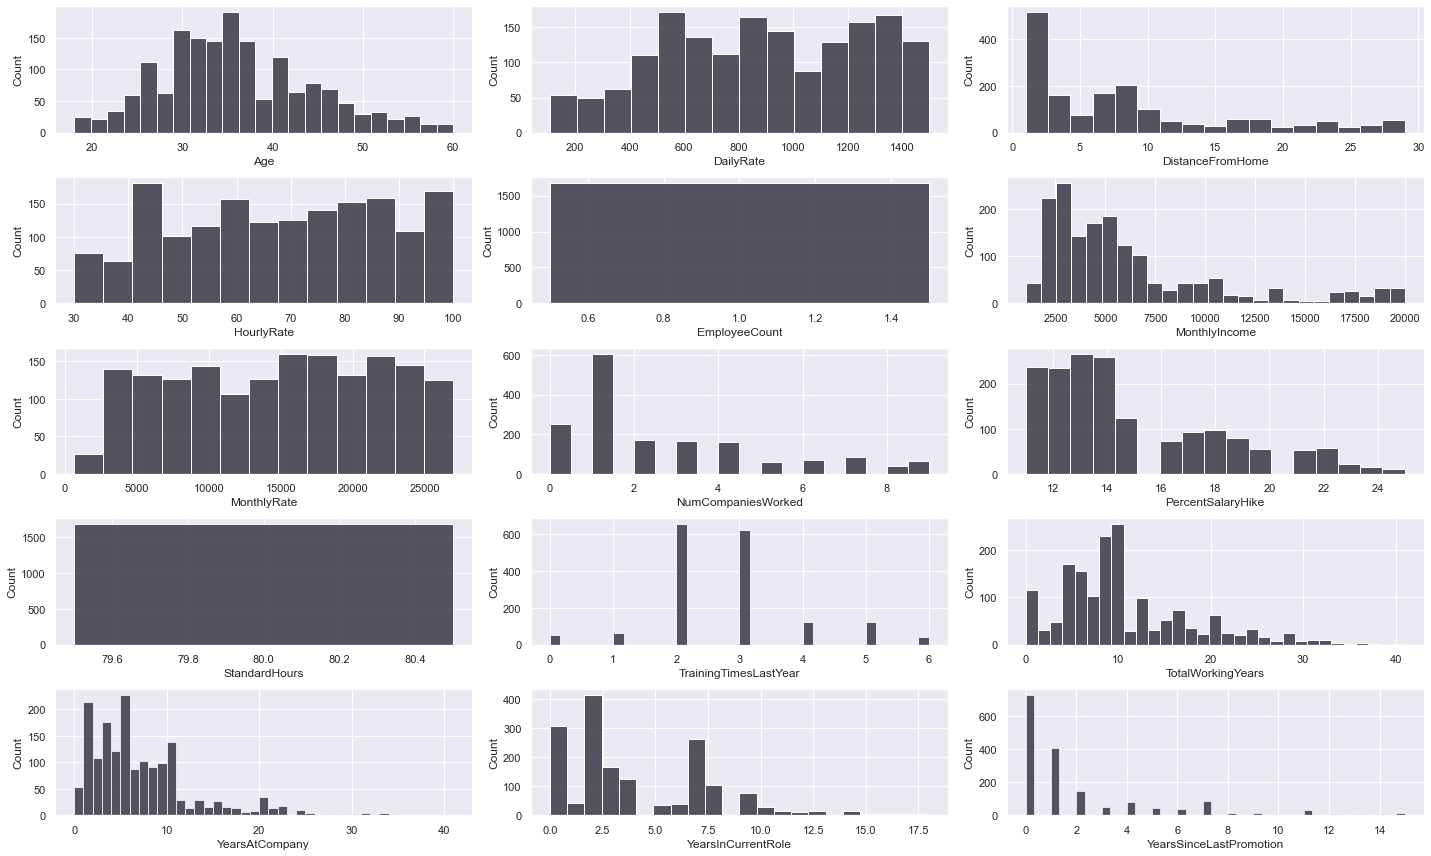

In [12]:
# Train set
fig, axes = plt.subplots(5,3, figsize=(20, 12))
for i, j in zip(num_features, axes.flatten()):
    sns.histplot(train[i], ax=j)
fig.tight_layout()
plt.show()

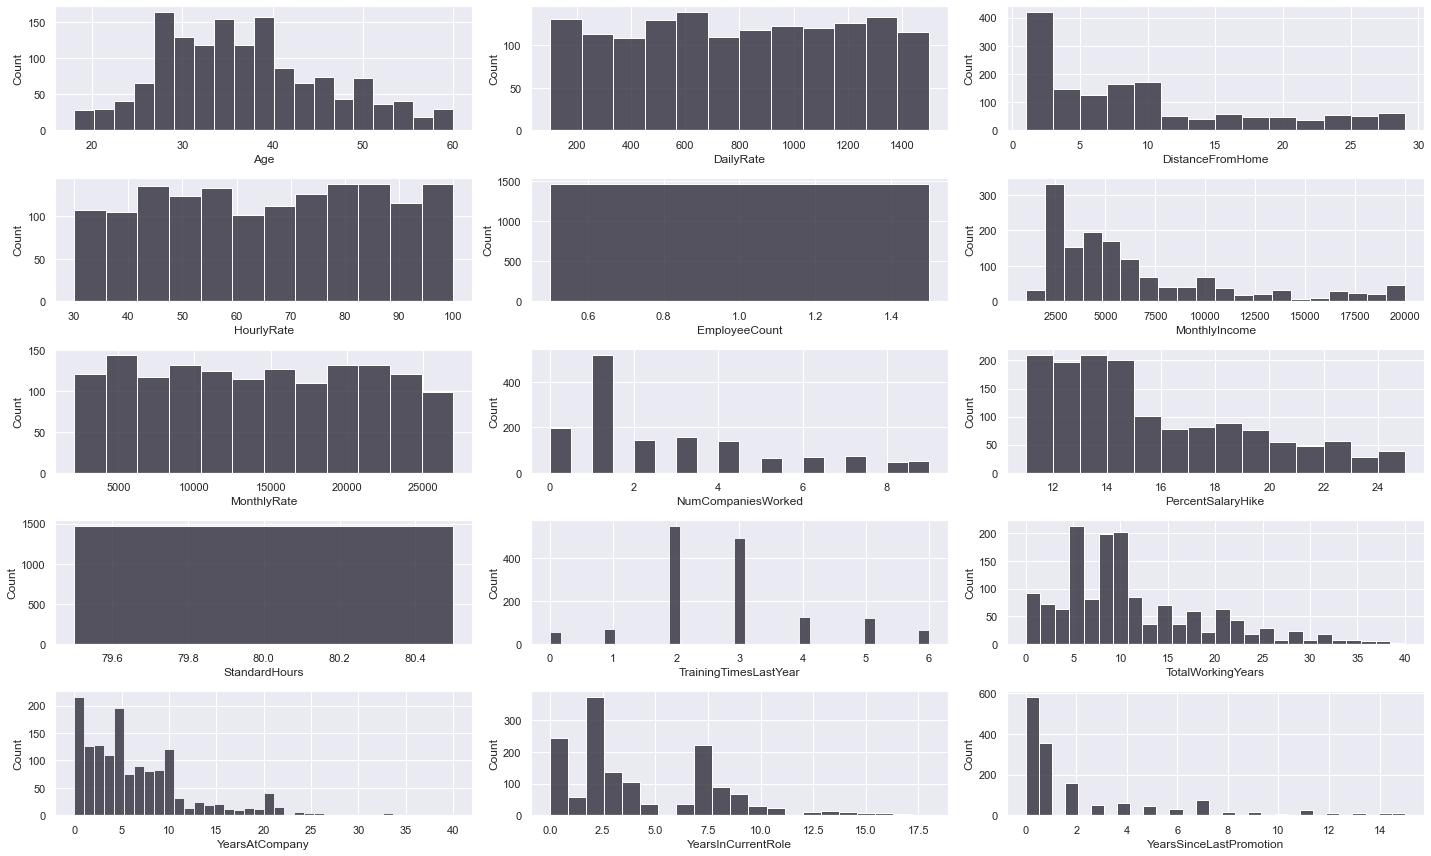

In [13]:
# original
fig, axes = plt.subplots(5,3, figsize=(20, 12))
for i, j in zip(num_features, axes.flatten()):
    sns.histplot(original[i], ax=j)
fig.tight_layout()
plt.show()

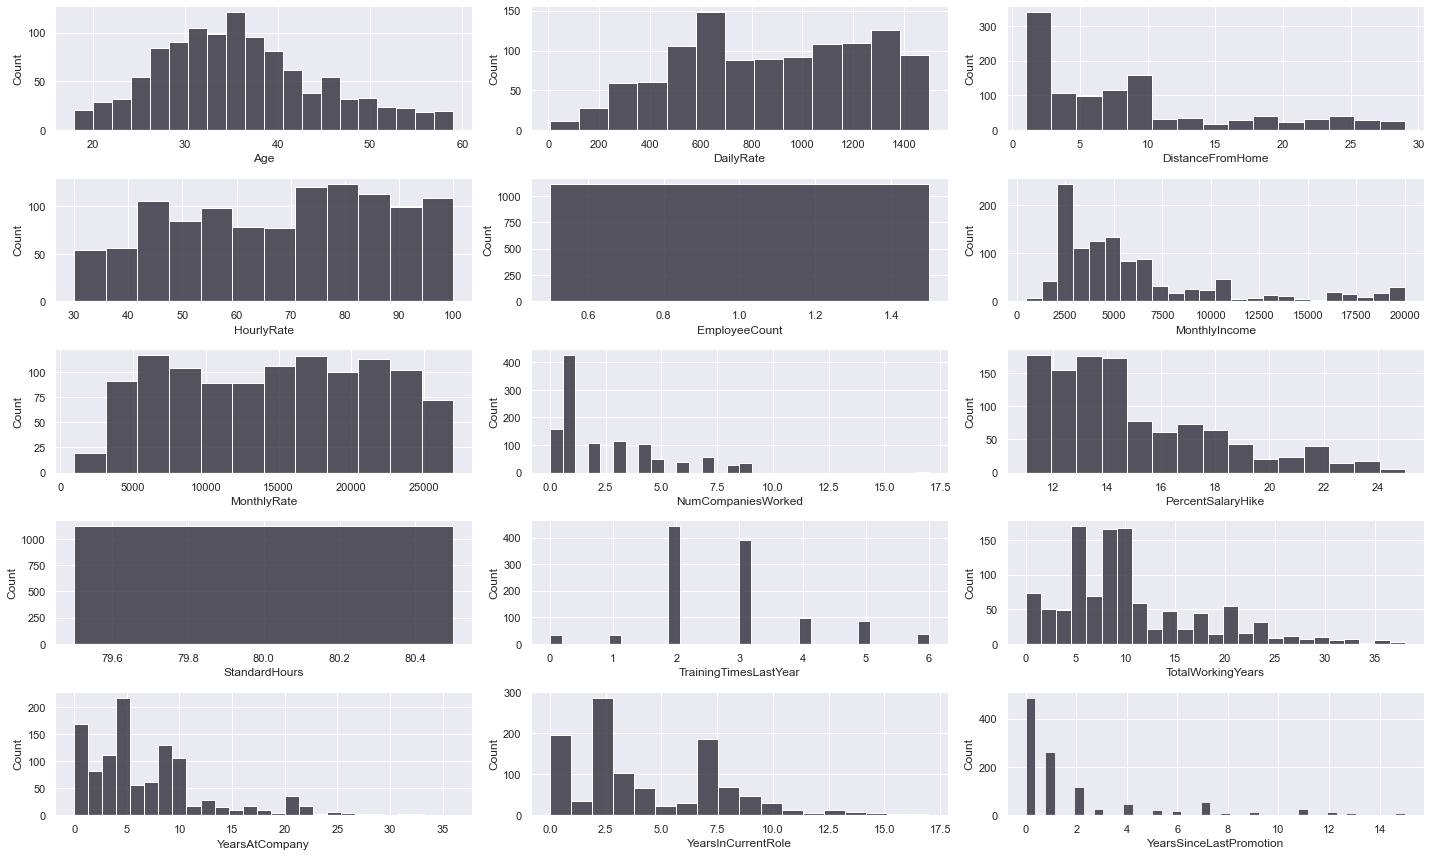

In [14]:
# Test set
fig, axes = plt.subplots(5,3, figsize=(20, 12))
for i, j in zip(num_features, axes.flatten()):
    sns.histplot(test[i], ax=j)
fig.tight_layout()
plt.show()

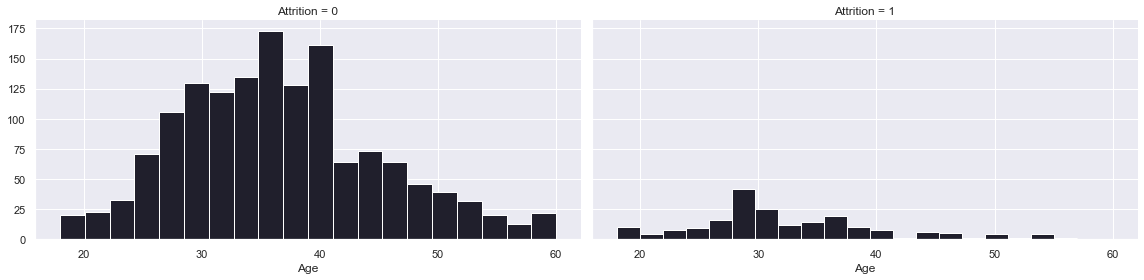

In [15]:
g = sns.FacetGrid(train, col='Attrition', height=4, aspect=2)
g.map(plt.hist, 'Age', bins=20)
plt.show()

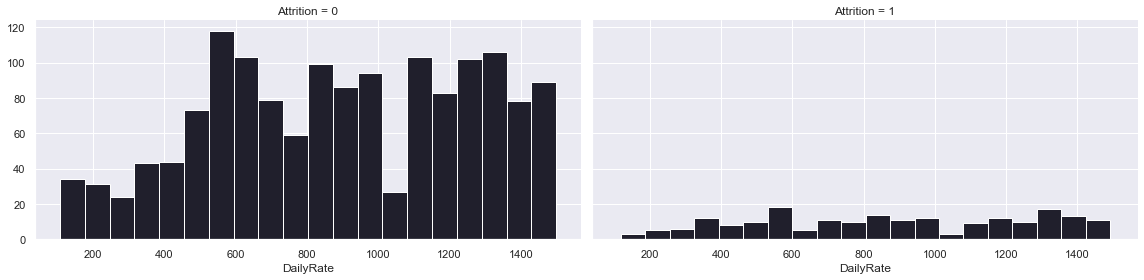

In [16]:
g = sns.FacetGrid(train, col='Attrition', height=4, aspect=2)
g.map(plt.hist, 'DailyRate', bins=20)
plt.show()

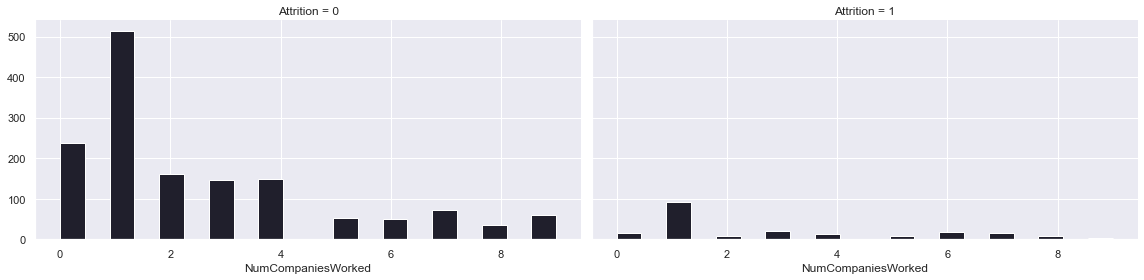

In [17]:
g = sns.FacetGrid(train, col='Attrition', height=4, aspect=2)
g.map(plt.hist, 'NumCompaniesWorked', bins=20)
plt.show()

### Categorical Features

In [18]:
cat_concat = pd.concat([train[cat_features+['source']], original[cat_features+['source']], test[cat_features+['source']]])

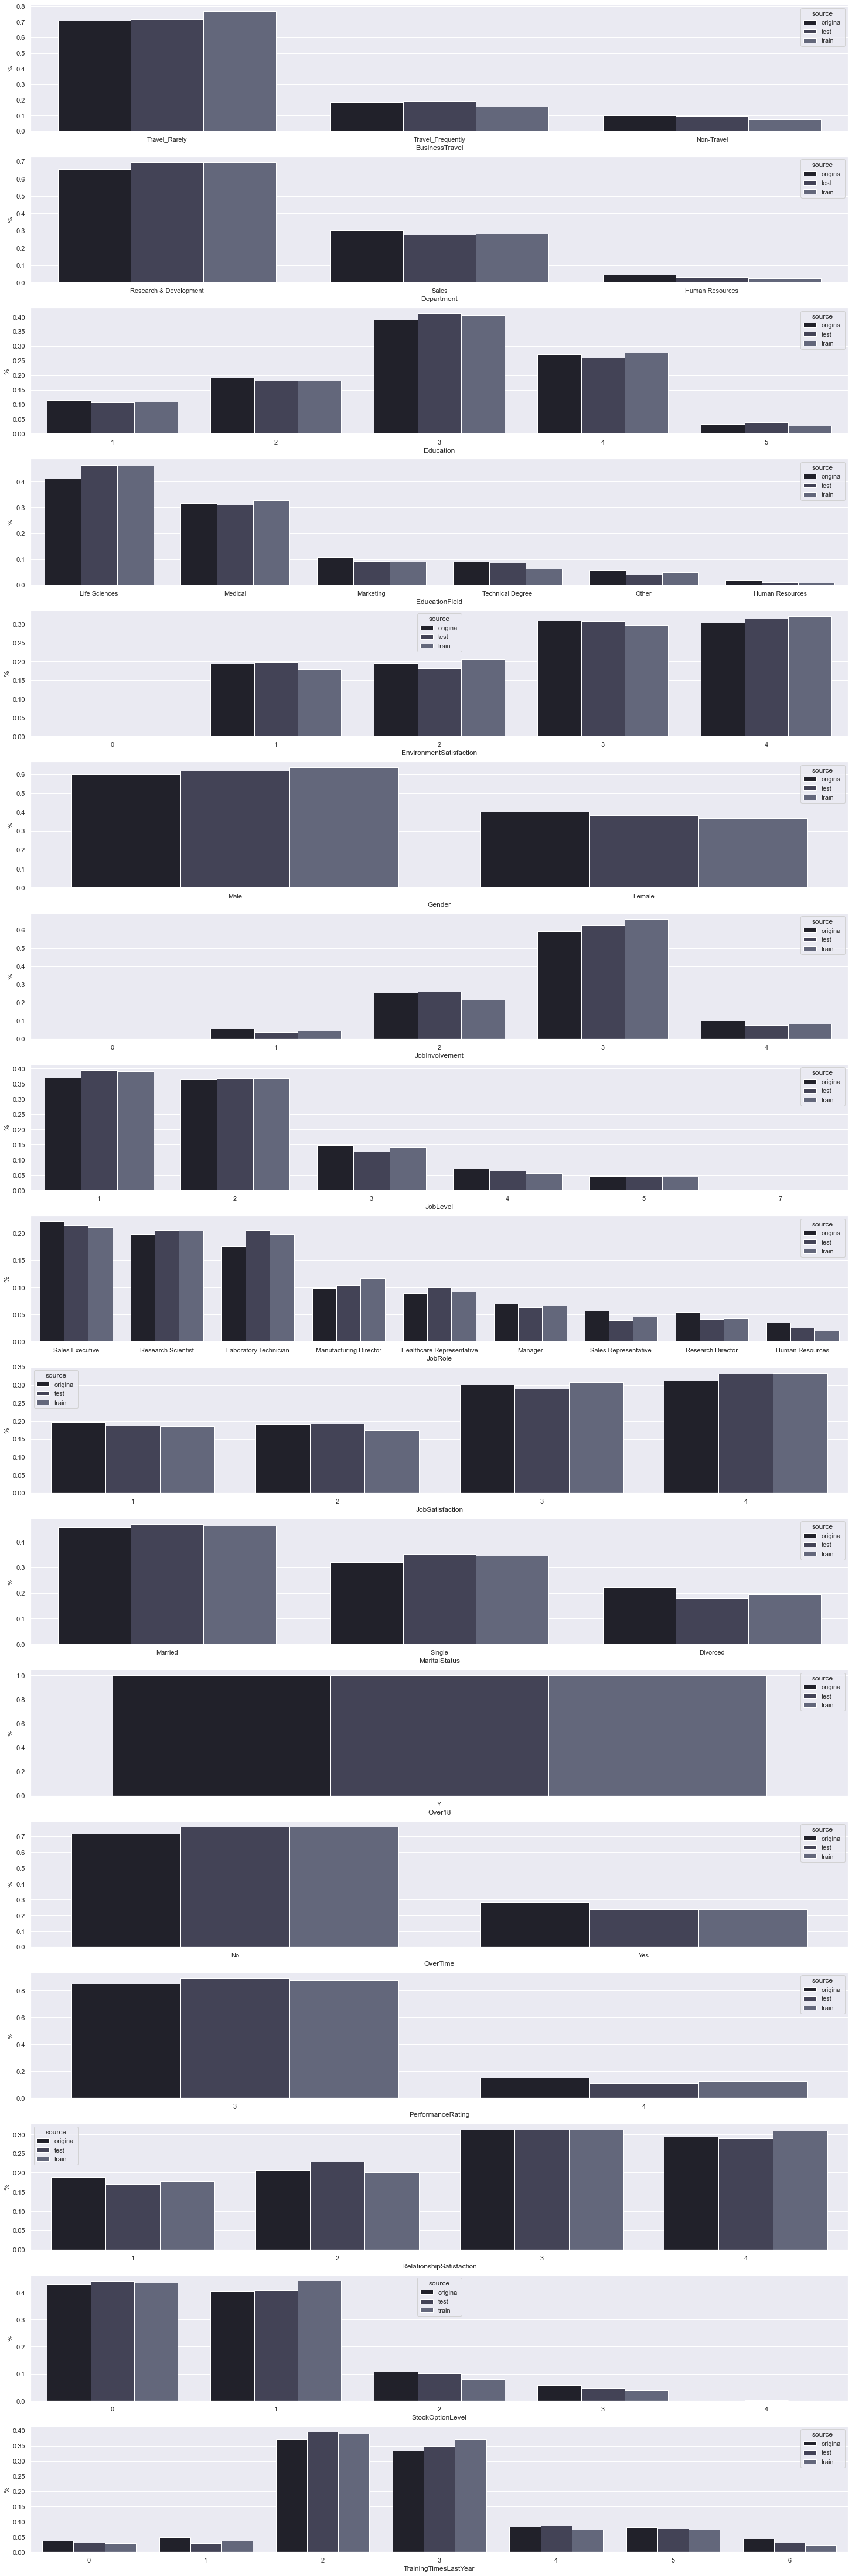

In [19]:
fig, axes = plt.subplots(17,1, figsize=(25, 80))
for i, j in zip(cat_features, axes.flatten()):
    data = cat_concat.groupby('source')[i].value_counts(True).rename('%').reset_index()
    sns.barplot(data=data, hue='source', x=i, y='%', ax=j)
    j.tick_params(axis='x')
plt.show()

In [20]:
train = train.drop('EmployeeCount', axis=1)
original = original.drop('EmployeeCount', axis=1)
test = test.drop('EmployeeCount', axis=1)
train = train.drop('StandardHours', axis=1)
original = original.drop('StandardHours', axis=1)
test = test.drop('StandardHours', axis=1)
train = train.drop('Over18', axis=1)
original = original.drop('Over18', axis=1)
test = test.drop('Over18', axis=1)

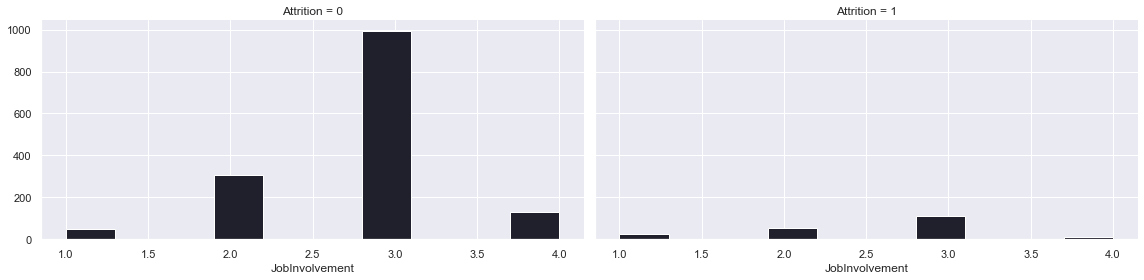

In [21]:
g = sns.FacetGrid(train, col='Attrition', height=4, aspect=2)
g.map(plt.hist, 'JobInvolvement')
plt.show()

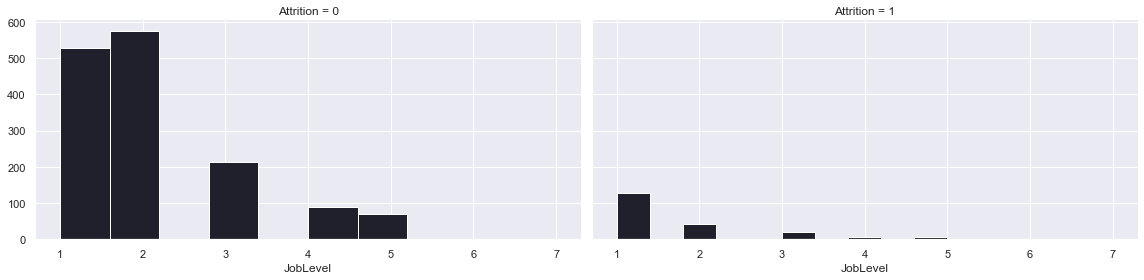

In [22]:
g = sns.FacetGrid(train, col='Attrition', height=4, aspect=2)
g.map(plt.hist, 'JobLevel')
plt.show()

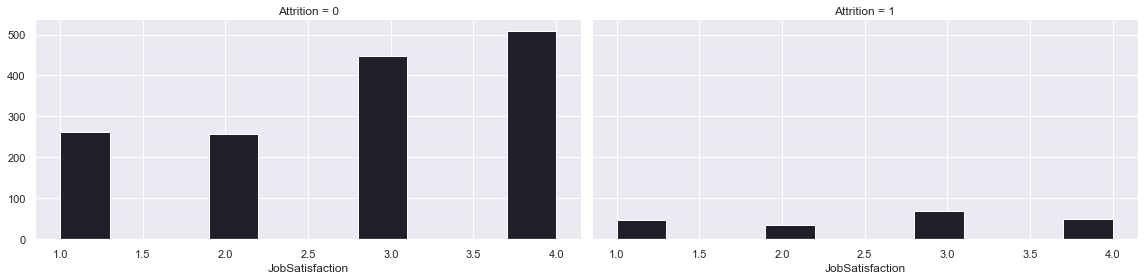

In [23]:
g = sns.FacetGrid(train, col='Attrition', height=4, aspect=2)
g.map(plt.hist, 'JobSatisfaction')
plt.show()

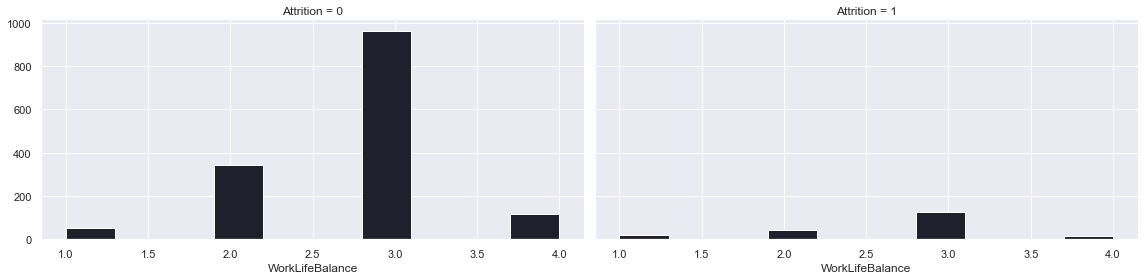

In [24]:
g = sns.FacetGrid(train, col='Attrition', height=4, aspect=2)
g.map(plt.hist, 'WorkLifeBalance')
plt.show()

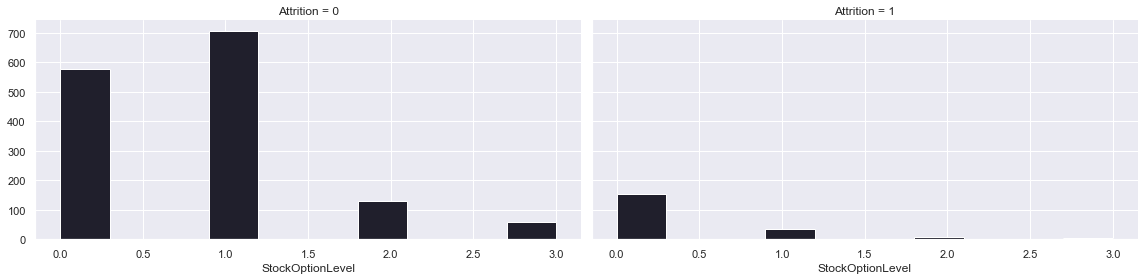

In [25]:
g = sns.FacetGrid(train, col='Attrition', height=4, aspect=2)
g.map(plt.hist, 'StockOptionLevel')
plt.show()

### Target

In [26]:
target_concat = pd.concat([train[[target, 'source']], original[[target, 'source']]])

In [27]:
# Train Set
print('Train Set')
display(pd.DataFrame(train['Attrition'].value_counts()).reset_index().rename(columns={'index':'Attrition', 'Attrition':'count'}))
# Original
print('Original')
display(pd.DataFrame(original['Attrition'].value_counts()).reset_index().rename(columns={'index':'Attrition', 'Attrition':'count'}))

Train Set


,Attrition,count
0,0,1475
1,1,200


Original


,Attrition,count
0,0,1233
1,1,237


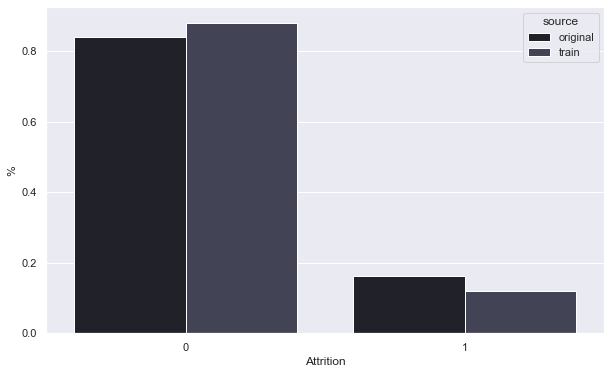

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))
data = target_concat.groupby('source')[target].value_counts(True).rename('%').reset_index()
sns.barplot(data=data, hue='source', x=target, y='%')
plt.show()

## Construct new features

In [29]:
def is_young(x):
    if x <=25:
        return 1
    else:
        return 0
    
def young_and_low_daily_rate(x):
    if x['Age'] <= 25 & x['DailyRate'] < 500:
        return 1
    else:
        return 0

In [30]:
train['is_young'] = train['Age'].apply(lambda x: is_young(x))
train['young_and_underpaid'] = train.apply(lambda x: young_and_low_daily_rate(x), axis = 1)
train['worklife_stock'] = train.apply(lambda x: x['WorkLifeBalance'] + x['StockOptionLevel'], axis = 1)
train['Job'] = train.apply(lambda x: x['JobInvolvement'] + x['JobLevel'] + x['JobSatisfaction'], axis = 1)

original['is_young'] = original['Age'].apply(lambda x: is_young(x))
original['young_and_underpaid'] = original.apply(lambda x: young_and_low_daily_rate(x), axis = 1)
original['worklife_stock'] = original.apply(lambda x: x['WorkLifeBalance'] + x['StockOptionLevel'], axis = 1)
original['Job'] = original.apply(lambda x: x['JobInvolvement'] + x['JobLevel'] + x['JobSatisfaction'], axis = 1)

test['is_young'] = test['Age'].apply(lambda x: is_young(x))
test['young_and_underpaid'] = test.apply(lambda x: young_and_low_daily_rate(x), axis = 1)
test['worklife_stock'] = test.apply(lambda x: x['WorkLifeBalance'] + x['StockOptionLevel'], axis = 1)
test['Job'] = test.apply(lambda x: x['JobInvolvement'] + x['JobLevel'] + x['JobSatisfaction'], axis = 1)

## Correlation matrix (Heatmap Style)

In [31]:
train['source'] = 1
test['source'] = 1
original['source'] = 0

num_features = ['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome', 
                'MonthlyRate','NumCompaniesWorked', 'PercentSalaryHike', 'TrainingTimesLastYear', 
                'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
                'YearsWithCurrManager']

cat_features = ['BusinessTravel', 'Department','Education', 'EducationField', 'EnvironmentSatisfaction',
                'Gender', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
                'OverTime', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'Job',
                'TrainingTimesLastYear', 'WorkLifeBalance','is_young', 'young_and_underpaid', 'worklife_stock']

target = 'Attrition'

<AxesSubplot:>

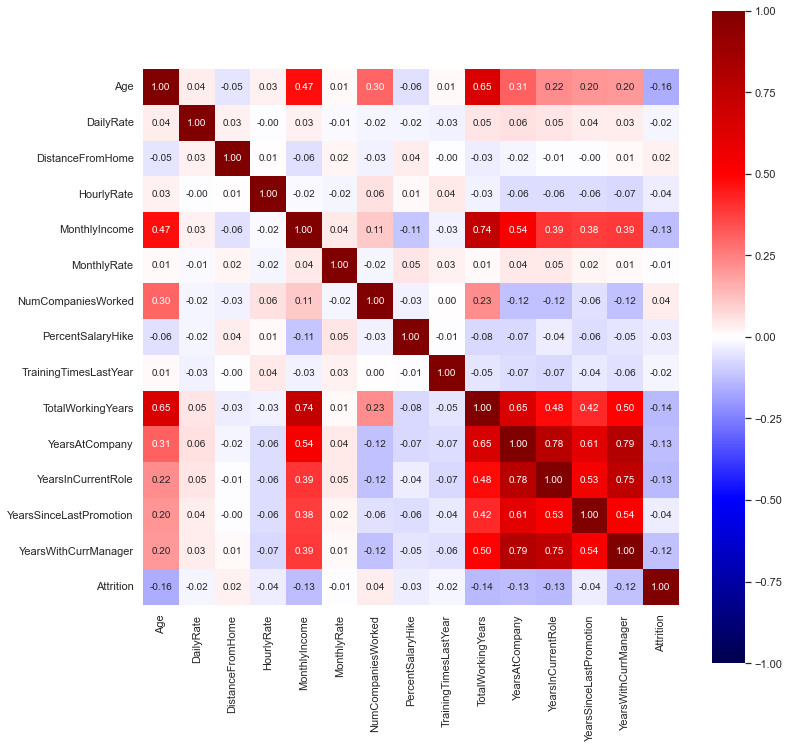

In [32]:
# Train Set
corrmat = train[num_features+[target]].corr()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat, square=True, annot=True, fmt='.2f', cmap='seismic', vmin=-1, vmax=1)

<AxesSubplot:>

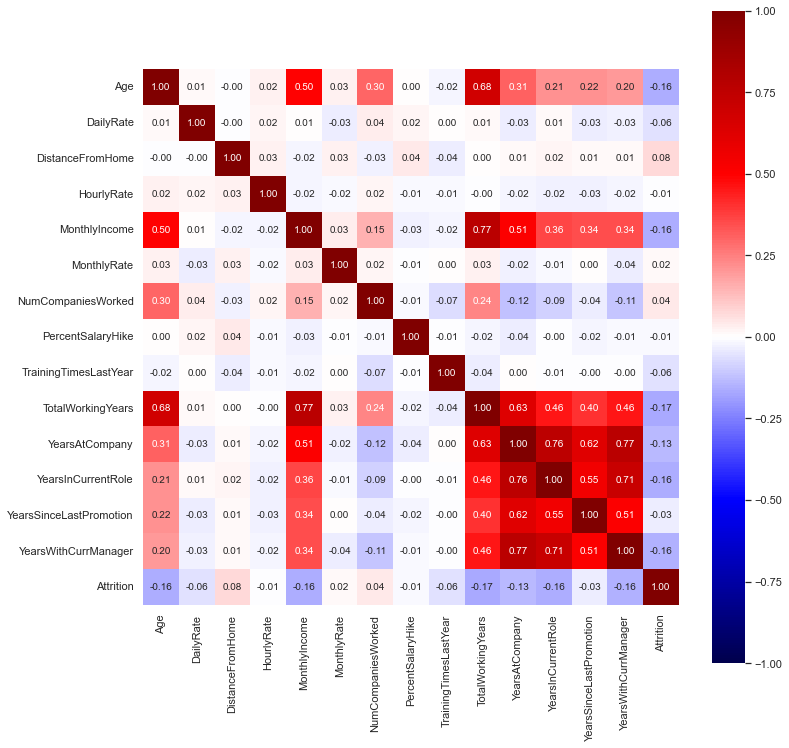

In [33]:
# Original
corrmat = original[num_features+[target]].corr()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat, square=True, annot=True, fmt='.2f', cmap='seismic', vmin=-1, vmax=1)

# Train Model

In [34]:
train = pd.concat([train, original])
train.reset_index(inplace=True, drop=True)

In [35]:
all_features = train.drop(['id', target], axis=1).columns

In [37]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import category_encoders as ce
from sklearn.metrics import classification_report,confusion_matrix

In [38]:
encoders = {
    'BackwardDifferenceEncoder': ce.backward_difference.BackwardDifferenceEncoder,
    'BaseNEncoder': ce.basen.BaseNEncoder,
    'BinaryEncoder': ce.binary.BinaryEncoder,
    'CatBoostEncoder': ce.cat_boost.CatBoostEncoder,
    'HashingEncoder': ce.hashing.HashingEncoder,
    'HelmertEncoder': ce.helmert.HelmertEncoder,
    'JamesSteinEncoder': ce.james_stein.JamesSteinEncoder,
    'OneHotEncoder': ce.one_hot.OneHotEncoder,
    'LeaveOneOutEncoder': ce.leave_one_out.LeaveOneOutEncoder,
    'MEstimateEncoder': ce.m_estimate.MEstimateEncoder,
    'OrdinalEncoder': ce.ordinal.OrdinalEncoder,
    'PolynomialEncoder': ce.polynomial.PolynomialEncoder,
    'SumEncoder': ce.sum_coding.SumEncoder,
    'TargetEncoder': ce.target_encoder.TargetEncoder,
    'WOEEncoder': ce.woe.WOEEncoder
}
import warnings
warnings.filterwarnings('ignore')

In [39]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train[all_features], train['Attrition'],stratify=train['Attrition'])

In [40]:
def test_model(selected_model):
  
  df_results = pd.DataFrame(columns=['encoder', 'f1', 'accuracy','roc'])

  for key in encoders:

      categorical_transformer = Pipeline(
          steps=[
              ('encoder', encoders[key]())
          ]
      )    

      preprocessor = ColumnTransformer(
          transformers=[
              ('categorical', categorical_transformer, cat_features),
              
          ]
      )

      pipe = Pipeline(
          steps=[
              ('preprocessor', preprocessor),
              ('classifier', selected_model)
          ]
      )

      model = pipe.fit(X_train, y_train)
      y_pred = model.predict(X_test)

      row = {
          'encoder': key,
          'f1': f1_score(y_test, y_pred, average='macro'),
          'accuracy': accuracy_score(y_test, y_pred),
          'roc': roc_auc_score(y_test, y_pred,)
      }

      df_results = df_results.append(row, ignore_index=True)
  print(df_results)
  return df_results

In [41]:
params = {'loss_function': 'CrossEntropy',
          'learning_rate': 0.76,
          'l2_leaf_reg': 0.014,
          'colsample_bylevel': 0.06,
          'depth': 1,
          'boosting_type': 'Plain',
          'bootstrap_type': 'Bernoulli',
          'min_data_in_leaf': 18,
          'subsample': 0.8,
         'verbose':0}
clf = CatBoostClassifier(**params,
                        iterations=20000,
                        eval_metric='AUC',
                        random_state=42)
test_model(clf)

                      encoder        f1  accuracy       roc
0   BackwardDifferenceEncoder  0.735830  0.894536  0.700110
1                BaseNEncoder  0.706275  0.885642  0.671849
2               BinaryEncoder  0.706275  0.885642  0.671849
3             CatBoostEncoder  0.608577  0.836086  0.596892
4              HashingEncoder  0.686810  0.880559  0.653501
5              HelmertEncoder  0.735830  0.894536  0.700110
6           JamesSteinEncoder  0.733193  0.894536  0.696260
7               OneHotEncoder  0.735830  0.894536  0.700110
8          LeaveOneOutEncoder  0.462799  0.861499  0.500000
9            MEstimateEncoder  0.733193  0.894536  0.696260
10             OrdinalEncoder  0.733193  0.894536  0.696260
11          PolynomialEncoder  0.735830  0.894536  0.700110
12                 SumEncoder  0.735830  0.894536  0.700110
13              TargetEncoder  0.733193  0.894536  0.696260
14                 WOEEncoder  0.735830  0.894536  0.700110


,encoder,f1,accuracy,roc
0,BackwardDifferenceEncoder,0.735830,0.894536,0.700110
1,BaseNEncoder,0.706275,0.885642,0.671849
2,BinaryEncoder,0.706275,0.885642,0.671849
3,CatBoostEncoder,0.608577,0.836086,0.596892
4,HashingEncoder,0.686810,0.880559,0.653501
5,HelmertEncoder,0.735830,0.894536,0.700110
6,JamesSteinEncoder,0.733193,0.894536,0.696260
7,OneHotEncoder,0.735830,0.894536,0.700110
8,LeaveOneOutEncoder,0.462799,0.861499,0.500000
9,MEstimateEncoder,0.733193,0.894536,0.696260


In [42]:
from category_encoders import WOEEncoder

for col in cat_features:
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)
    
en = WOEEncoder()
en.fit(train[all_features], train['Attrition'], cols = cat_features)
train[all_features] = en.transform(train[all_features])
test[all_features] = en.transform(test[all_features])

## XGBClassifier

In [43]:
import warnings
warnings.filterwarnings('ignore')

clfs = []
scores1 = []
scores2 = []
kf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

params = {'max_depth': 3,
          'learning_rate': 0.1,
          'min_child_weight': 5,
          'subsample': 0.7,
          'colsample_bytree': 0.3,
          'tree_method': 'gpu_hist'
         }

for i, (train_index, val_index) in enumerate(kf.split(train, y=train['Attrition'])):
    X_train, X_val = train[all_features].loc[train_index], train[all_features].loc[val_index]
    y_train, y_val = train[target][train_index], train[target][val_index]
    
    X_val_without_original, y_val_without_original = X_val[X_val['source'] == 1], y_val.loc[X_val[X_val['source'] == 1].index]
    
    clf = XGBClassifier(**params,
                        n_estimators=20000,
                        seed=42)
    
    clf.fit(X_train.values, y_train,
            early_stopping_rounds=100, 
            eval_set=[(X_val_without_original.values, y_val_without_original)], 
            eval_metric=['auc'],
            verbose=1000)
    
    preds1 = clf.predict_proba(X_val_without_original.values)
    auc1 = roc_auc_score(y_val_without_original, preds1[:, 1])
    preds2 = clf.predict_proba(X_val.values)
    auc2 = roc_auc_score(y_val, preds2[:, 1])
    
    clfs.append(clf)
    scores1.append(auc1)
    scores2.append(auc2)
    print(f'Score on fold {i} (without original data): {auc1}')
    print(f'Score on fold {i} (with original data): {auc2}')
    print('-'*75)
    
print(f'Mean score across all folds (without original data): {np.mean(scores1)}')
print(f'Mean score across all folds (with original data): {np.mean(scores2)}')

[0]	validation_0-auc:0.73418
[206]	validation_0-auc:0.83414
Score on fold 0 (without original data): 0.8418491484184915
Score on fold 0 (with original data): 0.8451023146595104
---------------------------------------------------------------------------
[0]	validation_0-auc:0.69736
[234]	validation_0-auc:0.86454
Score on fold 1 (without original data): 0.8755144032921811
Score on fold 1 (with original data): 0.8682489097618249
---------------------------------------------------------------------------
[0]	validation_0-auc:0.70246
[416]	validation_0-auc:0.86634
Score on fold 2 (without original data): 0.8755336617405582
Score on fold 2 (with original data): 0.8638040925863805
---------------------------------------------------------------------------
[0]	validation_0-auc:0.80872
[188]	validation_0-auc:0.91748
Score on fold 3 (without original data): 0.9225560727888278
Score on fold 3 (with original data): 0.8833445152633344
----------------------------------------------------------------

## LGBMClassifier

In [44]:
scores1 = []
scores2 = []

params = {'learning_rate': 0.09,
          'num_leaves': 195,
          'max_depth': 2,
          'min_child_samples': 46,
          'reg_alpha': 0.05,
          'reg_lambda': 0.1,
          'subsample': 0.45,
          'colsample_bytree': 0.3}

for i, (train_index, val_index) in enumerate(kf.split(train, y=train['Attrition'])):
    X_train, X_val = train[all_features].loc[train_index], train[all_features].loc[val_index]
    y_train, y_val = train[target][train_index], train[target][val_index]
    
    X_val_without_original, y_val_without_original = X_val[X_val['source'] == 1], y_val.loc[X_val[X_val['source'] == 1].index]
    
    clf = lgbm.LGBMClassifier(**params,
                              n_estimators=20000,
                              metric='auc',
                              random_state=42)
    
    clf.fit(X_train.values, y_train, 
            eval_set=[(X_val_without_original.values, y_val_without_original)],
            eval_metric=['auc'],
            callbacks=[lgbm.early_stopping(100, verbose=True)])
            
    preds1 = clf.predict_proba(X_val_without_original.values)
    auc1 = roc_auc_score(y_val_without_original, preds1[:, 1])
    preds2 = clf.predict_proba(X_val.values)
    auc2 = roc_auc_score(y_val, preds2[:, 1])
    
    clfs.append(clf)
    scores1.append(auc1)
    scores2.append(auc2)
    print(f'Score on fold {i} (without original data): {auc1}')
    print(f'Score on fold {i} (with original data): {auc2}')
    print('-'*75)
    
print(f'Mean score across all folds (without original data): {np.mean(scores1)}')
print(f'Mean score across all folds (with original data): {np.mean(scores2)}')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[142]	valid_0's auc: 0.836172
Score on fold 0 (without original data): 0.8361719383617194
Score on fold 0 (with original data): 0.8449345857094934
---------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[226]	valid_0's auc: 0.868313
Score on fold 1 (without original data): 0.868312757201646
Score on fold 1 (with original data): 0.8721905400872191
---------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[282]	valid_0's auc: 0.896223
Score on fold 2 (without original data): 0.8962233169129721
Score on fold 2 (with original data): 0.8888795706138878
---------------------------------------------------------------------------
Training until validation scores don't im

## CatBoostClassifier

In [45]:
scores1 = []
scores2 = []

params = {'loss_function': 'CrossEntropy',
          'learning_rate': 0.76,
          'l2_leaf_reg': 0.014,
          'colsample_bylevel': 0.06,
          'depth': 1,
          'boosting_type': 'Plain',
          'bootstrap_type': 'Bernoulli',
          'min_data_in_leaf': 18,
          'subsample': 0.8}

for i, (train_index, val_index) in enumerate(kf.split(train, y=train['Attrition'])):
    X_train, X_val = train[all_features].loc[train_index], train[all_features].loc[val_index]
    y_train, y_val = train[target][train_index], train[target][val_index]
    
    X_val_without_original, y_val_without_original = X_val[X_val['source'] == 1], y_val.loc[X_val[X_val['source'] == 1].index]
    
    clf = CatBoostClassifier(**params,
                            iterations=20000,
                            eval_metric='AUC',
                            random_state=42)
    
    clf.fit(X_train.values, y_train, 
            eval_set=(X_val_without_original.values, y_val_without_original),
            early_stopping_rounds=100, verbose=1000)
    
    preds1 = clf.predict_proba(X_val_without_original.values)
    auc1 = roc_auc_score(y_val_without_original, preds1[:, 1])
    preds2 = clf.predict_proba(X_val.values)
    auc2 = roc_auc_score(y_val, preds2[:, 1])
    
    clfs.append(clf)
    scores1.append(auc1)
    scores2.append(auc2)
    print(f'Score on fold {i} (without original data): {auc1}')
    print(f'Score on fold {i} (with original data): {auc2}')
    print('-'*85)
    
print(f'Mean score across all folds (without original data): {np.mean(scores1)}')
print(f'Mean score across all folds (with original data): {np.mean(scores2)}')

0:	test: 0.6265207	best: 0.6265207 (0)	total: 1.69ms	remaining: 33.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8625304136
bestIteration = 249

Shrink model to first 250 iterations.
Score on fold 0 (without original data): 0.8625304136253042
Score on fold 0 (with original data): 0.8623783965112379
-------------------------------------------------------------------------------------
0:	test: 0.5216049	best: 0.5216049 (0)	total: 2.87ms	remaining: 57.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8789437586
bestIteration = 170

Shrink model to first 171 iterations.
Score on fold 1 (without original data): 0.8789437585733882
Score on fold 1 (with original data): 0.8874538745387454
-------------------------------------------------------------------------------------
0:	test: 0.4824302	best: 0.4824302 (0)	total: 3.3ms	remaining: 1m 6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9047619048
bestIteration = 254

Shrink

## Feature importances

----------------------------XGBoost----------------------------


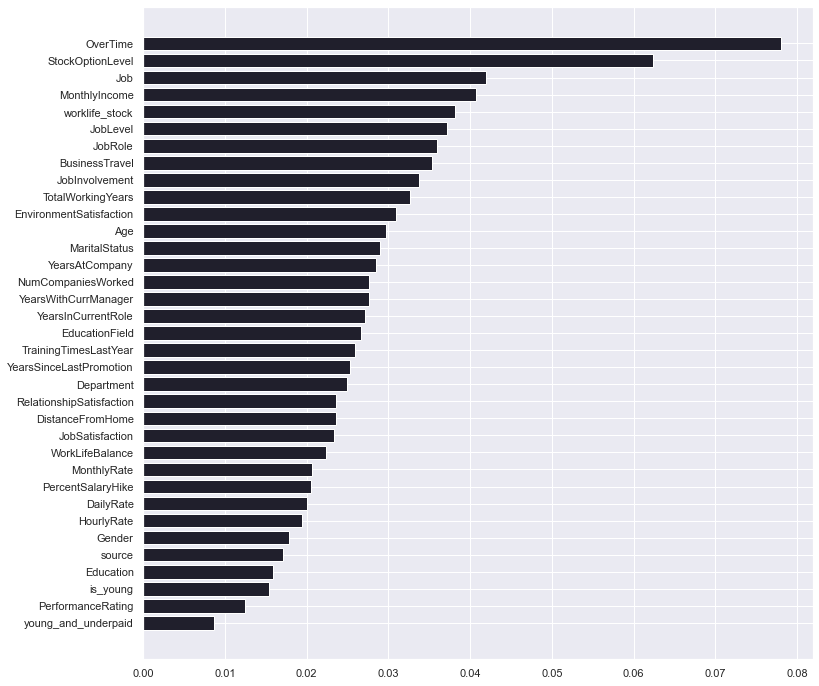

In [46]:
plt.figure(figsize=(12,12))
imp = np.zeros(35)
for clf in clfs[:10]:
    imp+= clf.feature_importances_
    
print('----------------------------XGBoost----------------------------')
plt.barh([all_features[i] for i in np.argsort(imp/10)], sorted(imp/10))
plt.show()

----------------------------LGBM----------------------------


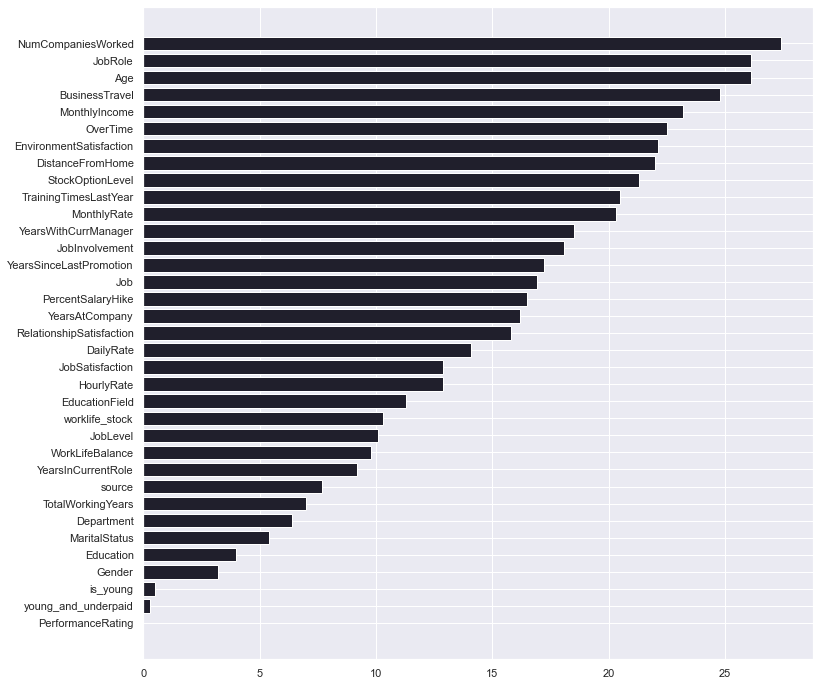

In [47]:
plt.figure(figsize=(12,12))
imp = np.zeros(35)
for clf in clfs[10:20]:
    imp+= clf.feature_importances_
    
print('----------------------------LGBM----------------------------')
plt.barh([all_features[i] for i in np.argsort(imp/10)], sorted(imp/10))
plt.show()

----------------------------CatBoost----------------------------


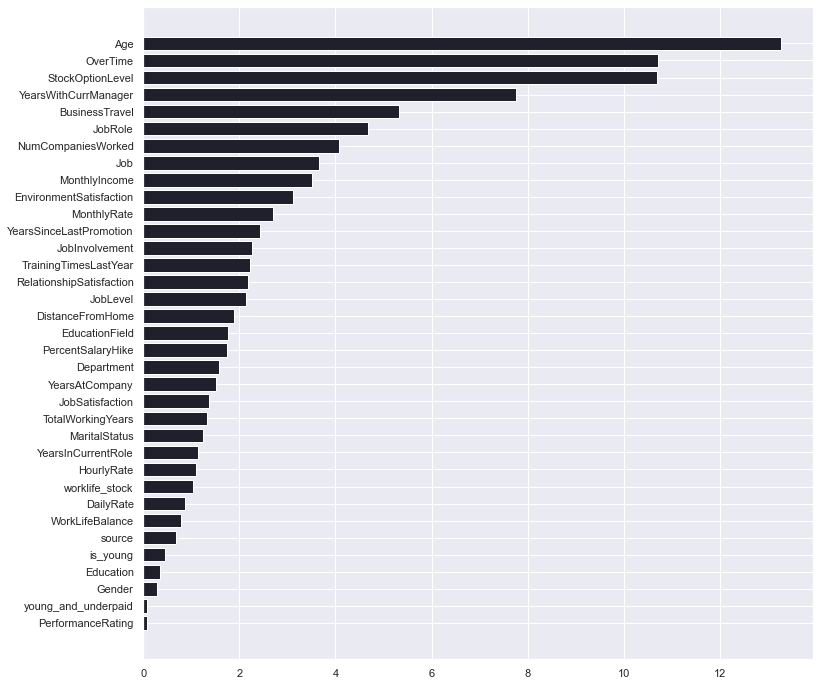

In [48]:
plt.figure(figsize=(12,12))
imp = np.zeros(35)
for clf in clfs[20:]:
    imp+= clf.feature_importances_
    
print('----------------------------CatBoost----------------------------')
plt.barh([all_features[i] for i in np.argsort(imp/10)], sorted(imp/10))
plt.show()

# Making submission

In [49]:
test_preds1 = []
test_preds2 = []
test_preds3 = []

for clf in clfs[:10]:
    preds = clf.predict_proba(test[all_features].values)
    test_preds1.append(preds[:, 1])
    
for clf in clfs[10:20]:
    preds = clf.predict_proba(test[all_features].values)
    test_preds2.append(preds[:, 1])
    
for clf in clfs[20:]:
    preds = clf.predict_proba(test[all_features].values)
    test_preds3.append(preds[:, 1])

In [50]:
test_preds1 = np.stack(test_preds1).mean(0)
test_preds2 = np.stack(test_preds2).mean(0)
test_preds3 = np.stack(test_preds3).mean(0)

In [51]:
test_preds = test_preds1*0.33 + test_preds2*0.33 + test_preds3*0.34

In [52]:
submission = pd.DataFrame(data={'id': test.id, 'Attrition': test_preds})
submission.head()

,id,Attrition
0,1677,0.187143
1,1678,0.130075
2,1679,0.055818
3,1680,0.069390
4,1681,0.520009


In [53]:
submission.to_csv('submission.csv', index=False)